In [1]:
import pandas as pd
import seaborn as sns
import nasdaqdatalink
import matplotlib.pyplot as plt
sns.set()
plt.rcParams['figure.figsize'] = (10, 8)

In [6]:
fetch_from_API = False

if fetch_from_API:
    nasdaqdatalink.ApiConfig.api_key = 'cMz6rH7NcNQz4NJeT4c6'
    ticker_dict = {'AAA': 'ML/AAAEY',
                   'A': 'ML/AEY',
                   'AA': 'ML/AAY',
                   'BBB': 'ML/BBBEY',
                   'BB': 'ML/BBY',
                   'B': 'ML/BEY',
                   'CCC': 'ML/CCCY'}
    tickers = [value for _, value in ticker_dict.items()]
    corp_data = nasdaqdatalink.get(tickers)
    corp_data.columns = [key for key, _ in ticker_dict.items()]
    
    ticker_dict = {'TBills': 'USTREASURY/YIELD'}
    tickers = [value for _, value in ticker_dict.items()]
    tbill_data = nasdaqdatalink.get(tickers)
    tbill_data.columns = ["TBILL_" + x.split("- ")[1].replace(" ", "").replace("O", "").replace("R", "") for x in tbill_data.columns]
    tbill_data = tbill_data[['TBILL_1Y']]
    
    data = pd.concat([corp_data, tbill_data], axis = 1)
    data.index.name = 'Date'
    data.dropna().to_csv('../../001_Data/CorpYields.csv')
else:
    data = pd.read_csv('../../001_Data/CorpYields.csv', index_col='Date')

In [7]:
data.sample(6)

,AAA,A,AA,BBB,BB,B,CCC,TBILL_1Y
Date,,,,,,,,
2020-01-17,2.50,2.58,2.35,3.10,3.56,5.02,11.20,1.56
2013-05-02,1.91,2.30,1.93,3.16,4.23,5.14,8.53,0.11
2016-12-28,3.10,3.14,2.80,3.84,4.67,6.08,11.71,0.90
2014-04-17,2.62,2.76,2.50,3.63,4.42,5.39,8.73,0.11
2013-04-25,1.95,2.34,1.99,3.21,4.33,5.39,8.86,0.12
2004-10-07,4.26,4.46,3.99,5.08,6.01,7.19,11.59,2.26


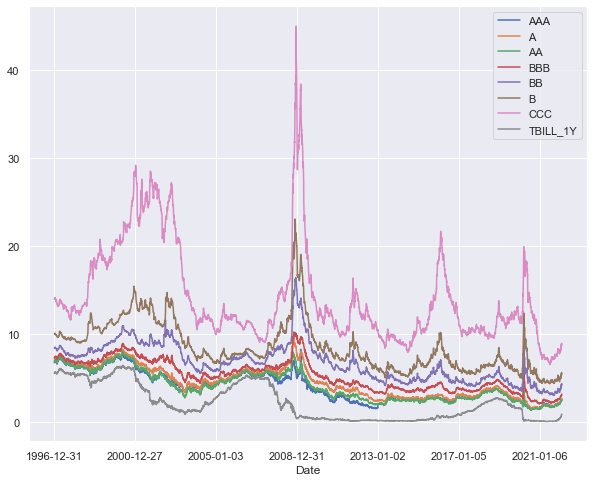

In [8]:
data.plot();

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6272 entries, 1996-12-31 to 2022-02-04
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AAA       6272 non-null   float64
 1   A         6272 non-null   float64
 2   AA        6272 non-null   float64
 3   BBB       6272 non-null   float64
 4   BB        6272 non-null   float64
 5   B         6272 non-null   float64
 6   CCC       6272 non-null   float64
 7   TBILL_1Y  6272 non-null   float64
dtypes: float64(8)
memory usage: 441.0+ KB


In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_pca_correlation_graph

In [11]:
data = (data - data['TBILL_1Y'].values.reshape(-1, 1)).drop('TBILL_1Y', axis=1)

In [12]:
diffs = data.diff().dropna()
sc = StandardScaler().fit(diffs)
diffs_std = sc.transform(diffs)

pca = PCA()
_ = pca.fit(diffs_std)

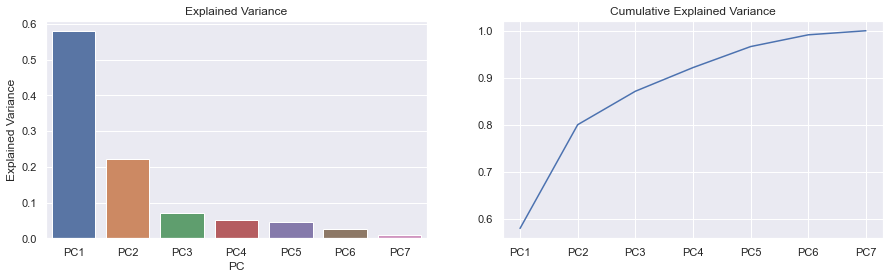

In [13]:
df = pd.DataFrame().from_dict({'PC': [f"PC{i+1}" for i, _ in enumerate(pca.explained_variance_ratio_)], 
                               'Explained Variance': pca.explained_variance_ratio_})
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='PC', y='Explained Variance', data = df, ax = ax[0])
ax[1].plot(df['PC'], df['Explained Variance'].cumsum())
ax[0].set_title('Explained Variance')
ax[1].set_title('Cumulative Explained Variance');

In [14]:
n_components = 3
pca = PCA(n_components)
projected = pca.fit_transform(diffs_std)
df_proj = pd.DataFrame(projected)
df_proj.columns = [f'PC{i+1}' for i in range(n_components)]
df_proj.index = diffs.index

<AxesSubplot:xlabel='Date'>

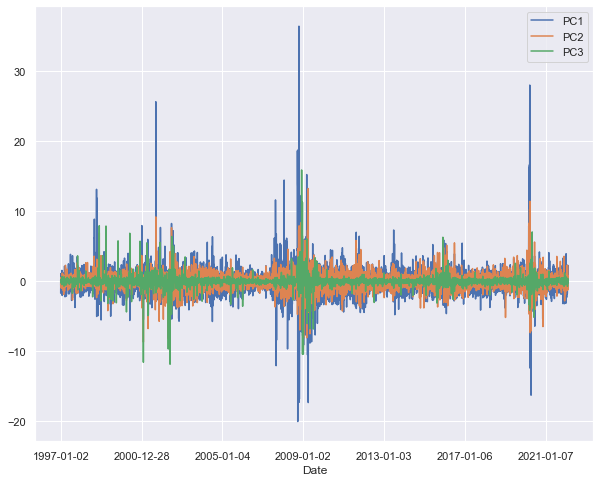

In [15]:
df_proj.plot()

,Dim 1,Dim 2
AAA,-0.758793,0.408907
A,-0.913939,0.297423
AA,-0.892916,0.341310
BBB,-0.888447,0.206037
BB,-0.660765,-0.557599
B,-0.628014,-0.608439
CCC,-0.476616,-0.670071


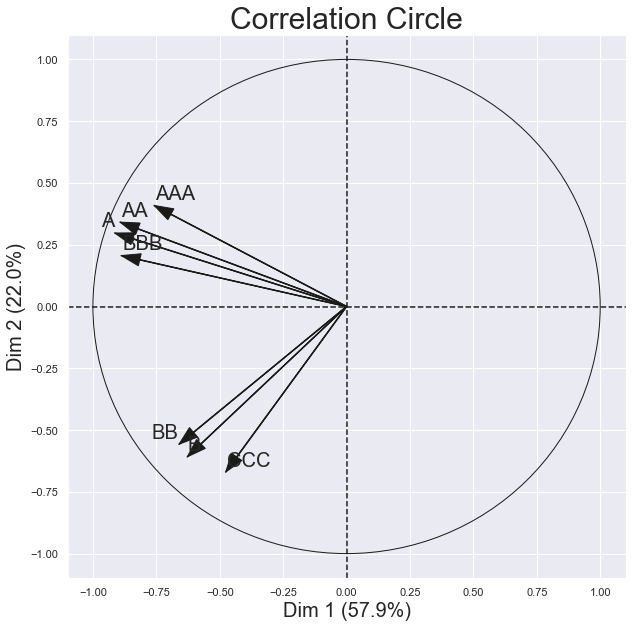

In [16]:
figure, correlation_matrix = plot_pca_correlation_graph(diffs_std,
                                                        diffs.columns,
                                                        dimensions=(1, 2),
                                                        figure_axis_size=10)
correlation_matrix